In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Dùng thư viện yfinance để tải dataset 
import yfinance as yf

In [26]:
df = pd.read_csv('BTC-USD.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2019,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09
1,1/2/2019,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09
2,1/3/2019,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09
3,1/4/2019,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09
4,1/5/2019,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09


In [28]:
df = df[['Date', 'Close']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
print(df)

                   Close
Date                    
2019-01-01   3843.520020
2019-01-02   3943.409424
2019-01-03   3836.741211
2019-01-04   3857.717529
2019-01-05   3845.194580
...                  ...
2023-03-27  27139.888670
2023-03-28  27268.130860
2023-03-29  28348.441410
2023-03-30  28033.562500
2023-03-31  28478.484380

[1551 rows x 1 columns]


In [29]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
print(x_train)
y_train = np.array(train_data['Close'])
print(y_train)

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

[['2019-01-01T00:00:00.000000000']
 ['2019-01-02T00:00:00.000000000']
 ['2019-01-03T00:00:00.000000000']
 ...
 ['2021-12-18T00:00:00.000000000']
 ['2021-12-19T00:00:00.000000000']
 ['2021-12-20T00:00:00.000000000']]
[ 3843.52002   3943.409424  3836.741211 ... 46848.77734  46707.01563
 46880.27734 ]
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=18326.915, Time=2.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18334.592, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18334.396, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18334.415, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18333.913, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=18338.414, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=18338.402, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=18328.615, Time=2.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=18328.727, Time=2.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18336.402, T

In [55]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

[47060.44417267 47306.98002779 47400.43473151 47291.38944196
 47143.01338451 47150.91932063 47338.58897684 47541.82894864
 47588.7019632  47478.27760966 47372.84103744 47421.193624
 47604.98856781 47766.32126954 47778.67322624 47676.54524514
 47611.42399726 47688.65137721 47860.51395819 47983.57437329
 47972.36352013 47885.07121031 47855.82855524 47951.6823126
 48106.48091938 48196.31536423 48171.010131   48102.39579621
 48103.5502947  48209.38868512 48344.44735815 48406.81600891
 48375.20557995 48326.90362974 48352.55466496 48461.44871345
 48576.0503505  48616.87376315 48585.03495102 48556.96684598
 48601.27718306 48707.98092265 48802.88230225 48827.8276066
 48800.20782226 48791.05031606 48848.59417058 48949.41763198
 49026.40340119 49040.59827944 49020.17800528 49027.78261025
 49093.77382643 49186.39302959 49247.88602207 49255.74380307
 49244.24689924 49265.99752458 49336.4160155  49419.64889124
 49468.38591994 49473.52267721 49471.64842483 49504.7515349
 49576.38759262 49649.9590694

In [43]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
print(last_index)
# last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
next_30_days_index = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index)
# Create an array of 30 consecutive integers starting from last_index
# x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days)) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
[47060.44417267 47306.98002779 47400.43473151 47291.38944196
 47143.01338451 47150.91932063 47338.58897684 47541.82894864
 47588.7019632  47478.27760966 47372.84103744 47421.193624
 47604.98856781 47766.32126954 47778.67322624 47676.54524514
 47611.42399726 47688.65137721 47860.51395819 47983.57437329
 47972.36352013 47885.07121031 47855.8285

Validation RMSE: 29593.898784807752
Testing RMSE: 25612.570333202642
Validation MAPE: 1.4947639255436262
Testing MAPE: 0.9374604237736818


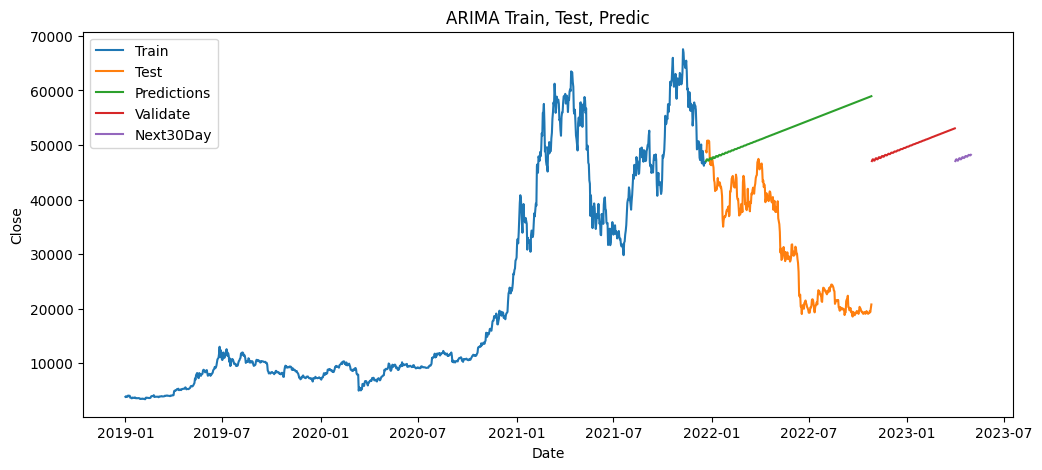

In [59]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMA Train, Test, Predic')
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index,y_next_30_days)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()